# LU Factorization

In this document, we will explore solving LU factorization using border bases and the companion method.

First, we load some preliminary libraries.

In [6]:
from __future__ import print_function
import sympy as sp
import numpy as np
import scipy as sc; import scipy.linalg
from scipy.linalg import norm
import BorderBasis as BB
np.set_printoptions(precision=3)
from IPython.display import display, Markdown, Math
sp.init_printing()

## LU Factorization

Let $A$ be a $d \times d$ matrix with a unique LU factorization $A = LU$, where $L$ and $U$ are respectively upper and lower diagonal.

A = 


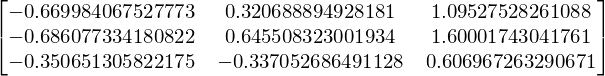

L = 


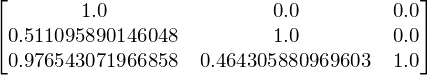

U = 


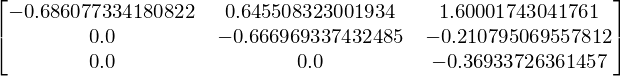

(None, None)

In [2]:
d = 3
A = np.random.randn(d,d)
_, L, U = sc.linalg.lu(A)
print("A = "), display(sp.Matrix(A))
print("L = "), display(sp.Matrix(L))
print("U = "), display(sp.Matrix(U))


Let us now encode the entries of $L$ and $U$ as variables and express the constraint $M = L U$ as a polynomial. Note that in our representation, we assume that the diagonal of $L$ is all $1$s. This is required for uniqueness.

In [3]:
# Define variables.
l_vars = [(i,j) for i in xrange(d) for j in xrange(i)]
u_vars = [(i,j) for i in xrange(d) for j in xrange(i, d)]
syms = ["l_%d%d"% (i+1,j+1) for i, j in l_vars] + ["u_%d%d"% (i+1,j+1) for i, j in u_vars]
R, syms = sp.xring(",".join(syms), sp.RR)
l_vars_ = dict(zip(l_vars, syms[:len(l_vars)]))
u_vars_ = dict(zip(u_vars, syms[len(l_vars):]))

# Construct equations.
def eqn(i,j):
    return sum(l_vars_.get((i,k), 1 if i == k else 0) * u_vars_.get((k,j), 0) for k in xrange(min(i,j)+1))
I = [eqn(i,j) - A[i,j] for i in xrange(d) for j in xrange(d)]
print("== Ring: "), display(R)
print("== Ideal: ")
for i in I: display(i.as_expr())

== Ring: 


Polynomial ring in l_21, l_31, l_32, u_11, u_12, u_13, u_22, u_23, u_33 over RR with lex order

== Ideal: 


Now let us find the corresponding border basis.

In [4]:
B = BB.BorderBasisFactory(1e-5).generate(R, I)
print("== Generators: ")
for b in B.generator_basis: display(b.as_expr())

== Generators: 


Observe how the border basis terms are actually the values of the elements of $L$ and $U$. Of course, quotient basis is simply the element $\{0\}$. The multiplication matrices will then give us $M_{l_{ij}} = \text{value}(l_{ij})$.

To confirm, we can compute the values of $L$ and $U$ and reformat them into a matrix:

L_ = 


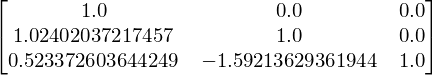

U_ = 


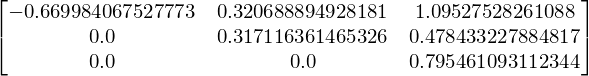

A - LU = 0.000


In [5]:
# Get the solutions
V = B.zeros()
V = V[0] # There is only one solution.
L_, U_ = np.eye(d), np.zeros((d,d))
for idx, (i,j) in enumerate(l_vars):
    L_[i,j] = V[idx]
for idx, (i,j) in enumerate(u_vars):
    U_[i,j] = V[len(l_vars)+idx]

print("L_ = "), display(sp.Matrix(L_))
print("U_ = "), display(sp.Matrix(U_))
print("A - LU = %.3f" % norm(A - L_.dot(U_)))

Note that these solutions are a little different from the ones obtained by the SciPy routine. This is because the scipy routine does some reordering for stability purposes.

## Looking deeper into the solution procedure
It maybe a little surprising to have observe that the border basis elements are just the solutions we were looking for! To see what's happening in a little more depth, let's look at the intermediate representations outputted by our system.

In [9]:
import globals # Hacky way I'm keeping track of intermediate information.
for stage, iteration, W in globals.info.Ws:
    display(Markdown("### Expansion %d, Iteration %d"%(stage, iteration)))
    for w in W:
        display(globals.info.L.as_poly(w).as_expr())


### Expansion 0, Iteration 0

### Expansion 0, Iteration 1

### Expansion 0, Iteration 2

First, note that we only expand our computational universe once. Intuitively, we never need elements with degree greater than 2 for our calculations, so our computational universe is sufficient.

Secondly, at the end of the first iteration, we are derive new linear equations, for $l_{21}$, $l_{31}$, $u_{22}$ and $u_{23}$ by eliminating $u_{21}$ and $u_{31}$.

In the next iteration, we get linear equations of $l_{32}$ and $u_{33}$ by eliminating the variables obtained in the previous iteration.

Finally, in the last iteration, we derive no new linear equations, and our procedure terminates.